In [12]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing

import lightgbm as lgb

df = pd.read_csv('../data/df_reg.csv',encoding='cp932')

In [6]:
# htmlのサマリーが必要であれば実行
from ydata_profiling import ProfileReport
profile = ProfileReport(df)

profile.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:215: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:215: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If t

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
df = pd.read_csv('../data/df_reg.csv',encoding='cp932')

'''
 'total_employee', 'minimum_wage',
       'setsubi',  'labor_alloc', 'luriage',
       'ln_added_value', 'ln_total_employee', 'ln_investment', 'labor_prod',
       'ln_min_wage_lag1', 'ln_min_wage_lag2', 'ln_min_wage_lag3', 'part_prop',
       'cgpi', 'koueki', 'unemp_rate', 'nilf_rate', 'pref', 'ind_large',
       'markup_class'
       のうち、0が含まれるものは0をNaNに変換する
'''
zeros_to_nan = [ 'total_employee', 'minimum_wage',
       'setsubi',  'labor_alloc', 'luriage',
       'ln_added_value', 'ln_total_employee', 'ln_investment', 'labor_prod',
       'ln_min_wage_lag1', 'ln_min_wage_lag2', 'ln_min_wage_lag3', 'part_prop',
       'cgpi', 'koueki', 'unemp_rate', 'nilf_rate', 'pref', 'ind_large',
       'markup_class']
for col in zeros_to_nan:
    df[col] = df[col].replace(0, np.nan)

df = df.drop(['minimum_wage'], axis=1)

categorical_vars = ["ind_large","markup_class"]
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

df_reg = df


In [14]:
tgt_vars  = ["added_value_ratio","labor_alloc","luriage",
             "ln_added_value","ln_total_employee","ln_investment","labor_prod"]

wage_vars = ["ln_min_wage_lag1","ln_min_wage_lag2","ln_min_wage_lag3"]



#dfの変数から、tgt_varsとwage_varsを除外したものを説明変数のリストとする
exog_vars = list(set(df.columns) - set(tgt_vars) - set(wage_vars))



In [16]:
#'luriage'を目的変数にして、exo_varsを説明変数とするlightgbmモデルを作成

# モデルのパラメータを指定する。'id_eternal'と'pref'はcategorical変数なので、
# 'categorical_feature'に指定する。
params = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': 10,
          'learning_rate': 0.01,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.8,
          'bagging_freq': 1,
          'verbose': 0,
          'num_threads': multiprocessing.cpu_count(),
          'seed': 1234}

#'pref'を1～47の数字に変換
df['pref'] = pd.factorize(df['pref'])[0] + 1

#目的変数から欠損値を除外して、0も除外

df = df.dropna(subset=['luriage'])
df = df[df['luriage'] > 0]


# 'id_eternal'と'pref'をcategorical_featureにするlightgbmの回帰モデルを作成
model = lgb.train(params,
                  lgb.Dataset(df[exog_vars],
                              label=df['luriage']),
                  num_boost_round=1000,
                  categorical_feature=['id_eternal', 'pref'])

# モデルの予測値と、目的変数との残差を計算
df['resid_luriage'] = df['luriage'] - model.predict(df[exog_vars])


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011552 seconds.
You can set `force_col_wise=true` to remove the overhead.


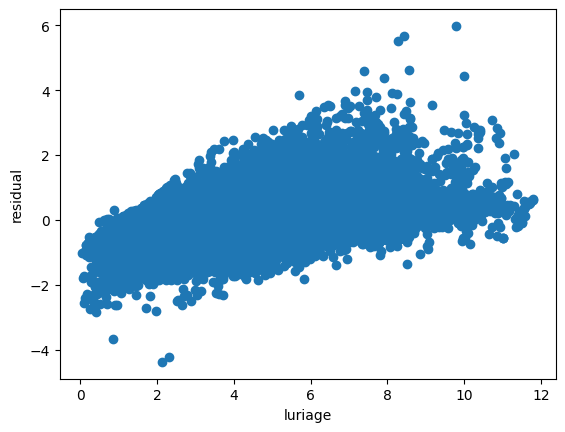

In [17]:
#dfの'luriage'と'resid'をプロットする
import matplotlib.pyplot as plt
plt.scatter(df['luriage'], df['resid'])
plt.xlabel('luriage')
plt.ylabel('residual')
plt.show()


In [ ]:
'''
- tgt_vars及びwage_varsを目的変数にして、exo_varsを説明変数とするlightgbmモデルを繰り返し実行する。
  この時、df_regを用いて実行し、それぞれの予測の結果をdfに追加し、それぞれの予測値と目的変数との残差も名前が重複しないようにdfに追加する。
- 'id_eternal'と'pref'はcategorical変数なので、'categorical_feature'に指定する。
- 'pref'を1～47の数字に変換する。
'''

## モデルの予測値と残差を保存するためのdf_resultを作成。これは、dfのid_eternalとyearをコピーしたものとする。
df_result = df[['id_eternal', 'year']].copy()

for tgt_var in tgt_vars:
    
    params = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': 10,
          'learning_rate': 0.01,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.8,
          'bagging_freq': 1,
          'verbose': 0,
          'num_threads': multiprocessing.cpu_count(),
          'seed': 1234}

    #'pref'を1～47の数字に変換
    df_reg['pref'] = pd.factorize(df_reg['pref'])[0] + 1

    #目的変数から欠損値を除外
    df_reg = df_reg.dropna(subset=[tgt_var])
    '''
    もし目的変数が、'labor_alloc','ln_total_employee','luriage','labor_prod'の場合は、0も除外する
       
    '''
    if tgt_var in ['labor_alloc','ln_total_employee','luriage','labor_prod']:
        df_reg = df_reg[df_reg[tgt_var] > 0]


    # 'id_eternal'と'pref'をcategorical_featureにするlightgbmの回帰モデルを作成
    model = lgb.train(params,
                      lgb.Dataset(df_reg[exog_vars],
                                  label=df_reg[tgt_var]),
                      num_boost_round=1000,
                      categorical_feature=['id_eternal', 'pref'])

    # モデルの予測値と、目的変数との残差を計算して,'id_eternal'と'year'をkeyとして
    # それぞれdf_resultに追加
    df_reg['pred_'+tgt_var] = model.predict(df_reg[exog_vars])
    df_reg['resid_'+tgt_var] = df_reg[tgt_var] - model.predict(df_reg[exog_vars])
    df_result = pd.merge(df_result, df_reg[['id_eternal', 'year',tgt_var, 'resid_'+tgt_var, 'pred_'+tgt_var]],
                         on=['id_eternal', 'year'], how='left')



    df_reg = df


In [26]:
#save df_result

df_result.to_csv('../data/df_result.csv', index=False)

In [27]:
'''
- tgt_vars及びwage_varsを目的変数にして、exo_varsを説明変数とするlightgbmモデルを繰り返し実行する。
  この時、df_regを用いて実行し、それぞれの予測の結果をdfに追加し、それぞれの予測値と目的変数との残差も名前が重複しないようにdfに追加する。
- 'id_eternal'と'pref'はcategorical変数なので、'categorical_feature'に指定する。
- 'pref'を1～47の数字に変換する。
'''
for tgt_var in wage_vars:
    
    params = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': 10,
          'learning_rate': 0.01,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.8,
          'bagging_freq': 1,
          'verbose': 0,
          'num_threads': multiprocessing.cpu_count(),
          'seed': 1234}

    #'pref'を1～47の数字に変換
    df_reg['pref'] = pd.factorize(df_reg['pref'])[0] + 1

    #目的変数から欠損値を除外
    df_reg = df_reg.dropna(subset=[tgt_var])
    '''
    もし目的変数が、'labor_alloc','ln_total_employee','luriage','labor_prod'の場合は、0も除外する
       
    '''
    if tgt_var in ['labor_alloc','ln_total_employee','luriage','labor_prod']:
        df_reg = df_reg[df_reg[tgt_var] > 0]


    # 'id_eternal'と'pref'をcategorical_featureにするlightgbmの回帰モデルを作成
    model = lgb.train(params,
                      lgb.Dataset(df_reg[exog_vars],
                                  label=df_reg[tgt_var]),
                      num_boost_round=1000,
                      categorical_feature=['id_eternal', 'pref'])

    # モデルの予測値と、目的変数との残差を計算して,'id_eternal'と'year'をkeyとして
    # それぞれdf_resultに追加
    df_reg['pred_'+tgt_var] = model.predict(df_reg[exog_vars])
    df_reg['resid_'+tgt_var] = df_reg[tgt_var] - model.predict(df_reg[exog_vars])
    df_result = pd.merge(df_result, df_reg[['id_eternal', 'year',tgt_var, 'resid_'+tgt_var, 'pred_'+tgt_var]],
                         on=['id_eternal', 'year'], how='left')



    df_reg = df

df_result.to_csv('../data/df_result_with_wage.csv', index=False)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012278 seconds.
You can set `force_col_wise=true` to remove the overhead.


/tmp/ipykernel_27447/3724491642.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['pred_'+tgt_var] = model.predict(df_reg[exog_vars])
/tmp/ipykernel_27447/3724491642.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['resid_'+tgt_var] = df_reg[tgt_var] - model.predict(df_reg[exog_vars])


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/tmp/ipykernel_27447/3724491642.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['pred_'+tgt_var] = model.predict(df_reg[exog_vars])
/tmp/ipykernel_27447/3724491642.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['resid_'+tgt_var] = df_reg[tgt_var] - model.predict(df_reg[exog_vars])


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005985 seconds.
You can set `force_col_wise=true` to remove the overhead.


/tmp/ipykernel_27447/3724491642.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['pred_'+tgt_var] = model.predict(df_reg[exog_vars])
/tmp/ipykernel_27447/3724491642.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['resid_'+tgt_var] = df_reg[tgt_var] - model.predict(df_reg[exog_vars])


In [36]:
df_result.columns


Index(['id_eternal', 'year', 'added_value_ratio', 'resid_added_value_ratio',
       'pred_added_value_ratio', 'labor_alloc', 'resid_labor_alloc',
       'pred_labor_alloc', 'luriage', 'resid_luriage', 'pred_luriage',
       'ln_added_value', 'resid_ln_added_value', 'pred_ln_added_value',
       'ln_total_employee', 'resid_ln_total_employee',
       'pred_ln_total_employee', 'ln_investment', 'resid_ln_investment',
       'pred_ln_investment', 'labor_prod', 'resid_labor_prod',
       'pred_labor_prod', 'ln_min_wage_lag1', 'resid_ln_min_wage_lag1',
       'pred_ln_min_wage_lag1', 'ln_min_wage_lag2', 'resid_ln_min_wage_lag2',
       'pred_ln_min_wage_lag2', 'ln_min_wage_lag3', 'resid_ln_min_wage_lag3',
       'pred_ln_min_wage_lag3'],
      dtype='object')

                   OLS Regression Results                  
Dep. Variable:                 target   F-statistic:       
Model:                            OLS   Prob (F-statistic):
No. Observations:              264399                      
Covariance Type:            nonrobust                      
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
resid_ln_min_wage_lag1    -0.0891      0.084     -1.066      0.287      -0.253       0.075
resid_ln_min_wage_lag2     0.0023      0.097      0.024      0.981      -0.187       0.192
resid_ln_min_wage_lag3    -0.1550      0.079     -1.965      0.049      -0.310      -0.000

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


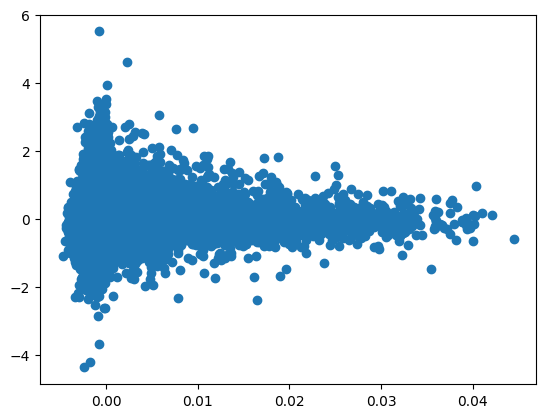

In [47]:
'''
df_resultにおいて、'resid_luriage'を目的変数として、
'resid_'+wage_varsを説明変数とする線形回帰モデルを作成する。
'''
import statsmodels.api as sms
from sklearn.linear_model import LinearRegression

# 'resid_luriage'を目的変数として、
# 'resid_'+wage_varsを説明変数とする線形回帰モデルを作成する。


df_for_dml = df_result.copy()
df_for_dml['target'] = df_result['resid_luriage']
df_for_dml = df_for_dml.dropna(subset=['target'])
df_for_dml = df_for_dml.dropna(subset=['resid_ln_min_wage_lag1'])
df_for_dml = df_for_dml.dropna(subset=['resid_ln_min_wage_lag2'])
df_for_dml = df_for_dml.dropna(subset=['resid_ln_min_wage_lag3'])

dml_reg = sms.OLS(df_for_dml['target'],
                    df_for_dml[['resid_ln_min_wage_lag1','resid_ln_min_wage_lag2','resid_ln_min_wage_lag3']])
dml_reg = dml_reg.fit()

# 線形回帰モデルの結果を表示
print(dml_reg.summary(slim=True))

# 線形回帰モデルの残差をプロット
plt.scatter(dml_reg.predict(df_for_dml[['resid_ln_min_wage_lag1','resid_ln_min_wage_lag2','resid_ln_min_wage_lag3']]),
            dml_reg.resid)